In [15]:
import datetime

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

%load_ext tensorboard

TensorFlow version: 2.7.0


In [17]:
# medv - target

train_df = pd.read_csv('boston_data.csv')

print('train_df.shape', train_df.shape)
train_df.head(2)

train_df.shape (404, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6


# EDA

In [3]:
train_df.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

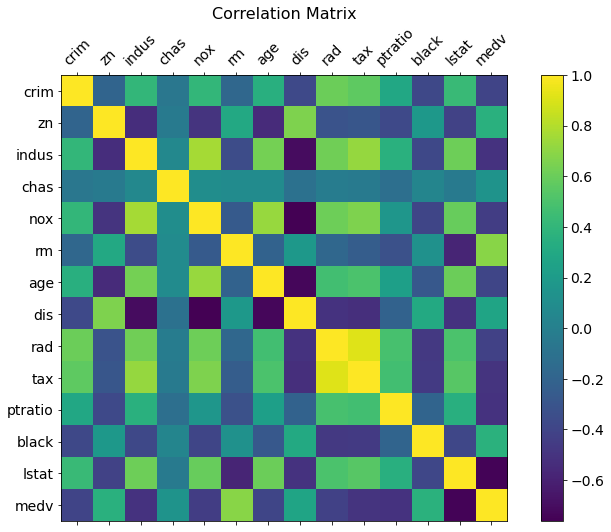

In [11]:
f = plt.figure(figsize=(12, 8))
plt.matshow(train_df.corr(), fignum=f.number)
plt.xticks(range(train_df.select_dtypes(['number']).shape[1]),
           train_df.select_dtypes(['number']).columns,
           fontsize=14,
           rotation=45)
plt.yticks(range(train_df.select_dtypes(['number']).shape[1]),
           train_df.select_dtypes(['number']).columns,
           fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [19]:
train_df.chas.value_counts(dropna=False)

0.0    376
1.0     28
Name: chas, dtype: int64

# Train / test prep

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.loc[:, train_df.columns != 'medv'],
                                                      train_df['medv'],
                                                      test_size=0.20)
X_train['rad'] = X_train['rad'].astype(int)
X_train['chas'] = X_train['chas'].astype(int)
X_valid['rad'] = X_valid['rad'].astype(int)
X_valid['chas'] = X_valid['chas'].astype(int)

# Baseline - CatBoostRegressor

In [23]:
cat_ft = ['rad', 'chas']
cb = CatBoostRegressor(iterations=10000,
                       learning_rate=0.1,
                       eval_metric='RMSE',
                       od_type='Iter',
                       metric_period = 50,
                       od_wait=50)
cb.fit(X_train, y_train,
       eval_set=(X_valid, y_valid),
       cat_features=cat_ft,
       use_best_model=True,
       verbose=True)

0:	learn: 8.5412341	test: 7.2565427	best: 7.2565427 (0)	total: 59.8ms	remaining: 9m 57s
50:	learn: 2.3490361	test: 3.0505119	best: 3.0505119 (50)	total: 138ms	remaining: 26.9s
100:	learn: 1.5975668	test: 2.7497768	best: 2.7497768 (100)	total: 215ms	remaining: 21.1s
150:	learn: 1.2310022	test: 2.6424656	best: 2.6415414 (146)	total: 285ms	remaining: 18.6s
200:	learn: 0.9137476	test: 2.5751109	best: 2.5744281 (199)	total: 352ms	remaining: 17.2s
250:	learn: 0.7072664	test: 2.5531429	best: 2.5531429 (250)	total: 421ms	remaining: 16.4s
300:	learn: 0.5690753	test: 2.5526508	best: 2.5458284 (263)	total: 489ms	remaining: 15.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.54582845
bestIteration = 263

Shrink model to first 264 iterations.


# DNN

## DNN Baseline

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          workers=6,
          epochs=10)

Epoch 1/10
11/11 [==============================] - 0s 10ms/step - loss: 1330.9996 - rmse: 36.4829 - val_loss: 223.0902 - val_rmse: 14.9362
Epoch 2/10
11/11 [==============================] - 0s 2ms/step - loss: 1068.3203 - rmse: 32.6852 - val_loss: 158.0146 - val_rmse: 12.5704
Epoch 3/10
11/11 [==============================] - 0s 2ms/step - loss: 1248.0105 - rmse: 35.3272 - val_loss: 142.3474 - val_rmse: 11.9309
Epoch 4/10
11/11 [==============================] - 0s 2ms/step - loss: 951.6519 - rmse: 30.8489 - val_loss: 104.9026 - val_rmse: 10.2422
Epoch 5/10
11/11 [==============================] - 0s 2ms/step - loss: 808.0149 - rmse: 28.4256 - val_loss: 94.6576 - val_rmse: 9.7292
Epoch 6/10
11/11 [==============================] - 0s 2ms/step - loss: 695.5161 - rmse: 26.3726 - val_loss: 97.2495 - val_rmse: 9.8615
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 644.9678 - rmse: 25.3962 - val_loss: 79.5113 - val_rmse: 8.9169
Epoch 8/10
11/11 [==================

## DNN + callbacks + glorot_uniform + relu

In [6]:
%%time
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error'),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/1/{epoch:02d}-{val_root_mean_squared_error:.2f}.hdf5',
                                       monitor='val_root_mean_squared_error',
                                       verbose=0,
                                       save_best_only=True)
]
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          workers=12,
          callbacks=callbacks,
          verbose=0,
          epochs=1000)

CPU times: user 1.53 s, sys: 419 ms, total: 1.95 s
Wall time: 1.42 s


## DNN + callbacks + glorot_uniform + elu

In [7]:
%%time
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error'),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/2/{epoch:02d}-{val_root_mean_squared_error:.2f}.hdf5',
                                       monitor='val_root_mean_squared_error',
                                       verbose=0,
                                       save_best_only=True)
]
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          workers=12,
          callbacks=callbacks,
          verbose=0,
          epochs=1000)

CPU times: user 6.67 s, sys: 2.01 s, total: 8.68 s
Wall time: 6.05 s


## DNN + callbacks + glorot_uniform + sigmoid

In [11]:
%%time
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error'),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/3/{epoch:02d}-{val_root_mean_squared_error:.2f}.hdf5',
                                       monitor='val_root_mean_squared_error',
                                       verbose=0,
                                       save_best_only=True)
]
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          workers=12,
          callbacks=callbacks,
          verbose=0,
          epochs=1000)

CPU times: user 9.01 s, sys: 2.59 s, total: 11.6 s
Wall time: 8.39 s


## DNN + callbacks + glorot_uniform + tanh

In [10]:
%%time
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error'),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/4/{epoch:02d}-{val_root_mean_squared_error:.2f}.hdf5',
                                       monitor='val_root_mean_squared_error',
                                       verbose=0,
                                       save_best_only=True)
]
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          workers=12,
          callbacks=callbacks,
          verbose=0,
          epochs=1000)

CPU times: user 3.04 s, sys: 813 ms, total: 3.85 s
Wall time: 2.83 s


## DNN + callbacks + glorot_uniform + gelu

In [12]:
%%time
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(128, activation='gelu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error'),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/5/{epoch:02d}-{val_root_mean_squared_error:.2f}.hdf5',
                                       monitor='val_root_mean_squared_error',
                                       verbose=0,
                                       save_best_only=True)
]
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          workers=12,
          callbacks=callbacks,
          verbose=0,
          epochs=1000)

CPU times: user 2.3 s, sys: 668 ms, total: 2.97 s
Wall time: 2.09 s


## DNN + callbacks + glorot_uniform + selu

In [13]:
%%time
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error'),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/6/{epoch:02d}-{val_root_mean_squared_error:.2f}.hdf5',
                                       monitor='val_root_mean_squared_error',
                                       verbose=0,
                                       save_best_only=True)
]
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          workers=12,
          callbacks=callbacks,
          verbose=0,
          epochs=1000)

CPU times: user 2.46 s, sys: 702 ms, total: 3.16 s
Wall time: 2.24 s


## DNN + callbacks + glorot_normal + relu + TensorBoard

In [16]:
%%time

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(128,
                          kernel_initializer=tf.keras.initializers.GlorotNormal(),
                          activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

log_dir = "tensorboards/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error'),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/6/{epoch:02d}-{val_root_mean_squared_error:.2f}.hdf5',
                                       monitor='val_root_mean_squared_error',
                                       verbose=0,
                                       save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]
model.fit(X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          workers=12,
          callbacks=callbacks,
          verbose=0,
          epochs=1000)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2002), started 0:00:56 ago. (Use '!kill 2002' to kill it.)

CPU times: user 1.65 s, sys: 315 ms, total: 1.96 s
Wall time: 1.62 s


In [ ]:
%tensorboard --logdir tensorboards